Pour cet exercice il nous est demandé :

PARTIE 1
Effectuer un partitionnement de X en 10 clusters, avec l’algorithme de clustering de notre choix.

PARTIE 2
Visualiser le résultat de ce clustering en deux dimensions.

PARTIE 3
Evaluer la qualité de ce partitionnement, d’une part intrinsèquement (sans utiliser y) et d’autre part en le comparant aux chiffres représentés par les images (en utilisant y).

In [3]:
# Modules sklearn nécessaires
from sklearn import cluster, metrics, decomposition, manifold
from sklearn.datasets import fetch_mldata
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Pour la séparation Training/Testing
from sklearn.model_selection import train_test_split

# Bibliothèqe Numpy de calculs
import numpy as np

# Affichage de plots
import matplotlib.pyplot as plt

In [4]:
# Récupération de la base de données MNIST original
mnist = fetch_mldata('MNIST original')

In [5]:
# Pour l'affichage dans le notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
# On vérifie le shape du dataset principal qui contient toutes les images pour vérifier que l'import s'est bien passé
print(mnist.data.shape)

# On vérifier le shape du vecteur d'annotations associé au dataset (nombre entre 0 et 9) pour les mêmes raisons
print(mnist.target.shape)

(70000, 784)
(70000,)


In [7]:
# On travaille sur une partie réduite des 70000 données qui sont disponibles, ici 2500.
sample = np.random.randint(70000, size=2500)
x_data = mnist.data[sample]
y_data = mnist.target[sample]

__PARTIE 1

Le partitionnement k-means est une méthode de partitionnement de données et un problème d'optimisation combinatoire. Étant donnés des points et un entier k, le problème est de diviser les points en k clusters, de façon à minimiser une certaine fonction. 

L'algorithme du k-means permet de rechercher efficacement une partition des données dont la variance intra-cluster est minimale (cependant il s'agit d'une approche heuristique qui peut retourner un minimum local plutôt que global).L'initialisation kmeans++ ainsi que des répétitions multiples permettent de mitiger ce problème.

Ici le nombre de cluster est imposée, n=10.

In [8]:
# création de l'objet cls
cls=cluster.KMeans(n_init=50,
                   n_clusters=10, 
                   init="k-means++",
                   max_iter=1000,
                   algorithm="auto")

In [9]:
# On le fit aux données
cls.fit(x_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=10, n_init=50, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

__PARTIE 2 

Essayons l'analyse en composante principale avec n=2

In [10]:
# PCA
print("Computing PCA")

# création de l'objet pca
pca=decomposition.PCA(n_components=2)
    
# application de l'objet
pca.fit(x_data)
print(pca.explained_variance_ratio_.cumsum())

Computing PCA
[ 0.09651871  0.16790755]


On ne peut donc pas utiliser l'analyse en composante principale car les deux premières composantes ne representent moins de 20 % de la variance totale. Cela n'aurait aucun sens.

On va essayer maintenant l'algorithme t-SNE, pour “t-distributed Stochastic Neighbor Embedding”. Cette technique permet de visualiser des données de grandes dimensions dans une variété de plus petite dimension. Nous allons essayer avec deux dimensions, ce qui nous permetterait de visualiser les résultats directement dans un graphique.

In [11]:
# t-SNE embedding
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, perplexity=40, n_iter=3000)

Computing t-SNE embedding


L'object a été créé, il faut maintenant "fiter" les données

In [12]:
# perform t-SNE embedding
x_tsne = tsne.fit_transform(x_data)

Pour plus de clarté, on décompose les deux composantes dans "col_x" et "col_y"

In [13]:
# Séparation des composantes
col_x = x_tsne[:, 0]
col_y = x_tsne[:, 1]

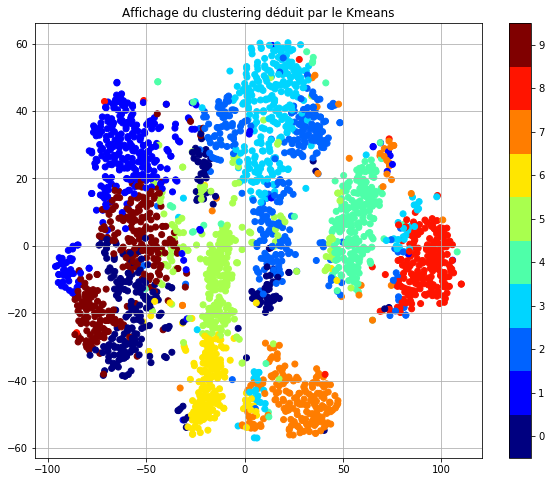

In [14]:
# taille de la figure
plt.figure(figsize=(10, 8))
plt.grid('on')

# Plot selon les deux composantes définies ci-dessus. On colorie suivant les 10 valeurs possibles de y-data (0--> 9 inclus)
plt.scatter(col_x, col_y, c=cls.labels_, cmap=plt.cm.get_cmap("jet", 10))

# couleurs
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

# Enfin, on affiche
plt.title("Affichage du clustering déduit par le Kmeans")
plt.show()

On peut également afficher un échantillon de 12 bons prédictions, puis un autre de 12 mauvaises prédictions.

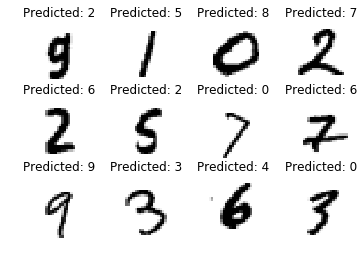

In [16]:
# On récupère les prédictions sur les données test
predicted = cls.labels_

# On redimensionne les données sous forme d'images
images = x_data.reshape((-1, 28, 28))

# On selectionne un echantillon de 12 images au hasard
select = np.random.randint(images.shape[0], size=12)

# On affiche les images avec la prédiction associée
for index, value in enumerate(select):
    plt.subplot(3,4,index+1)
    plt.axis('off')
    plt.imshow(images[value],cmap=plt.cm.gray_r,interpolation="nearest")
    plt.title('Predicted: %i' % predicted[value])

plt.show()

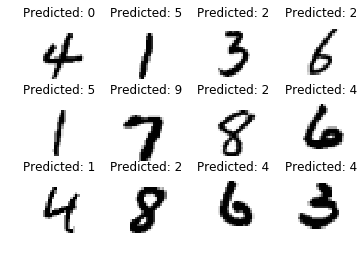

In [17]:
# on récupère les erreurs de prédiction
misclass = (y_data != predicted)
misclass_images = images[misclass,:,:]
misclass_predicted = predicted[misclass]

# on sélectionne un échantillon de ces images
select = np.random.randint(misclass_images.shape[0], size=12)

# on affiche les images et les prédictions (erronées) associées à ces images
for index, value in enumerate(select):
    plt.subplot(3,4,index+1)
    plt.axis('off')
    plt.imshow(misclass_images[value],cmap=plt.cm.gray_r,interpolation="nearest")
    plt.title('Predicted: %i' % misclass_predicted[value])

plt.show()

__PARTIE 3

Vérifions la qualité du clustering.

Affichons le graphique avec les données d'origine (y_data)

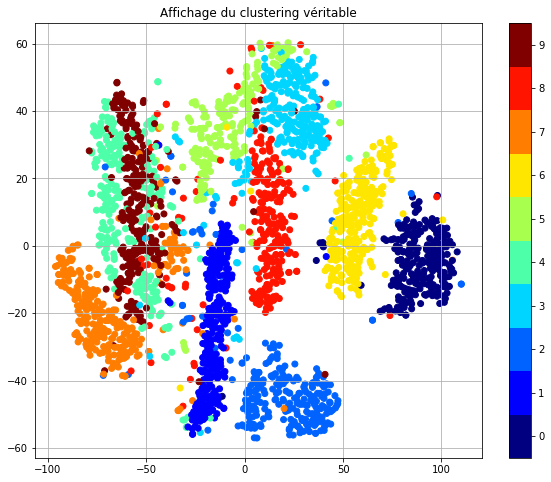

In [18]:
# taille de la figure
plt.figure(figsize=(10, 8))
plt.grid('on')

# Plot selon les deux composantes définies ci-dessus. On colorie suivant les 10 valeurs possibles de y-data (0--> 9 inclus)
plt.scatter(col_x, col_y, c=y_data, cmap=plt.cm.get_cmap("jet", 10))

# couleurs
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

# Enfin, on affiche
plt.title("Affichage du clustering véritable")
plt.show()

On peut aussi le calculer directement en regardant la différence entre les labels "proposés" par le partionnements kmeans (cls.labels) et les données d'origines (y_data)

In [19]:
print(metrics.adjusted_rand_score(y_data,cls.labels_))

0.341330217577


Le score n'est pas très bon. Même visuellement, on peut s'en rendre compte. Nous allons maintenant visualiser les résultats d'une autre manière.

La matrice de confusion, dans la terminologie de l'apprentissage supervisé, est un outil servant à mesurer la qualité d'un système de classification.

Chaque colonne de la matrice représente le nombre d'occurrences d'une classe estimée, tandis que chaque ligne représente le nombre d'occurrences d'une classe réelle (ou de référence). Les données utilisées pour chacun de ces groupes doivent être différentes.

Un des intérêts de la matrice de confusion est qu'elle montre rapidement si le système parvient à classifier correctement.

In [20]:
print(confusion_matrix(cls.labels_, y_data))

[[  2   0   7   7  59  29   0  67  49  39]
 [  1   0   8   5 114  10   7  51   4 106]
 [ 22   0   3  87   0  72   8   0 106   2]
 [ 23   0  24 122   0  62   2   0  63   4]
 [  4   1   8   4   6   2 196   0   2   0]
 [  0 143  11  16   6  17  16  19  17   9]
 [  1 125  16   2   3   4   2   4   6   2]
 [  3   0 184   4   2   0  19   1   0   0]
 [189   0   2   1   1   0   3   1   0   2]
 [  0   1   1   0  56   3   0 125   6  89]]


Une bonne matrice de confusion est une matrice "diagonale", et ce n'est pas le cas ici. Cela confirme nos suspicions d'un résultat moyen voire mauvais.

__PARTIE BONUS

Par curiosité, essayons deux autres techniques.

In [21]:
# Sépération training et testing sets
db_xtrain, db_xtest, db_ytrain, db_ytest = train_test_split(x_data, y_data, train_size=0.8)

C:\Users\Toni\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


__Technique 1 : Le k-NN.
On peut créer un premier classifieur x-NN, c'est à dire qui prend en compte les x plus proches voisins pour la classification.
Ici prenons x=10

In [22]:
knn = KNeighborsClassifier(n_neighbors=10)
digit_knn=knn.fit(db_xtrain, db_ytrain) 

Apprentissage et estimation de l'erreur de prévision sur l'échantillon test

In [23]:
print(1-digit_knn.score(db_xtest,db_ytest))

0.114


Cette valeur est très basse, le résultat est meilleur !

Faisons une réprésentation graphique pour visualiser les résultats. Reprenons le principe des parties déjà vues (et donc je n'explique pas une nouvelle fois).

Computing t-SNE embedding


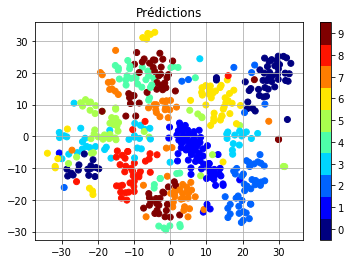

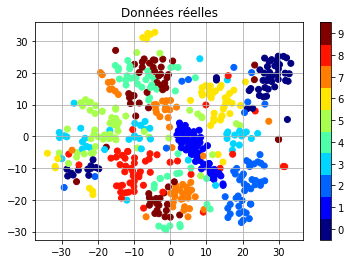

In [24]:
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, perplexity=40, n_iter=3000)
# perform t-SNE embedding
X_tsne = tsne.fit_transform(db_xtest)

# plot the result
vis_x = X_tsne[:, 0]
vis_y = X_tsne[:, 1]

# Affichage des prédictions
plt.title("Prédictions")
# knn.predict(db_test) = les prédictions sur les données test
plt.scatter(vis_x, vis_y, c=knn.predict(db_xtest), cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.grid('on')
plt.show()

# Affichage des données réelles
plt.title("Données réelles")
plt.scatter(vis_x, vis_y, c=db_ytest, cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.grid('on')
plt.show()

Reprenons la matrice de confusion

In [25]:
print(confusion_matrix(db_ytest, knn.predict(db_xtest)))

[[52  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 2  1 47  0  0  0  0  1  0  0]
 [ 0  2  0 38  0  0  1  0  2  0]
 [ 0  5  0  0 39  0  0  1  0  2]
 [ 1  2  0  3  0 41  2  0  0  4]
 [ 1  1  0  0  0  0 43  0  0  0]
 [ 0  2  0  0  0  0  0 48  0  1]
 [ 2  4  0  5  0  2  1  1 34  2]
 [ 0  0  1  1  1  0  0  2  1 51]]


On retrouve une diagonale presque parfaite, ce qui signifie que la séparation a été très bien faite.

__Technique 2 : RandomForestClassifier

In [26]:
rf = RandomForestClassifier(n_estimators=100, 
                            criterion='gini', 
                            max_depth=None, 
                            min_samples_split=2,
                            min_samples_leaf=1, 
                            max_features='auto', 
                            max_leaf_nodes=None, 
                            bootstrap=True, 
                            oob_score=True, 
                            n_jobs=-1,
                            random_state=None, 
                            verbose=0)
    
rf.fit(db_xtrain,db_ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

Faisons une réprésentation graphique pour visualiser les résultats. Reprenons le principe des parties déjà vues (et donc je n'explique pas une nouvelle fois).

Computing t-SNE embedding


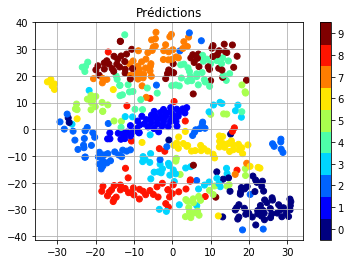

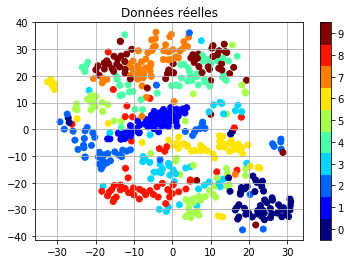

In [27]:
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, perplexity=40, n_iter=3000)
# perform t-SNE embedding
X_tsne = tsne.fit_transform(db_xtest)

# plot the result
vis_x = X_tsne[:, 0]
vis_y = X_tsne[:, 1]

# Affichage des prédictions
plt.title("Prédictions")
plt.scatter(vis_x, vis_y, c=rf.predict(db_xtest), cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.grid('on')
plt.show()

# Affichage des données réelles
plt.title("Données réelles")
plt.scatter(vis_x, vis_y, c=db_ytest, cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.grid('on')
plt.show()

In [28]:
# erreur sur l'échantillon test
print(1-rf.score(db_xtest,db_ytest))

0.088


L'erreur est très basse.

In [29]:
# Matrice de confusion
print(confusion_matrix(db_ytest, rf.predict(db_xtest)))

[[51  0  0  0  0  0  0  0  1  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  1  0  0  0]
 [ 1  1  1 35  1  1  0  1  2  0]
 [ 0  0  0  0 45  0  0  0  0  2]
 [ 0  0  0  4  0 43  0  0  2  4]
 [ 2  0  1  0  0  0 42  0  0  0]
 [ 0  1  1  0  0  0  0 47  1  1]
 [ 1  0  1  4  0  0  1  0 44  0]
 [ 1  0  2  0  4  1  0  0  0 49]]


La matrice de confusion confirme que les résultats des prédictions sont très bons car on retrouve une bonne diagonale.